"""
COMPLETELY NEW VERSION OF UNET DESIGNED FOR BRAIN TUMOUR SEGMENTATION

SPECS:

1. Input size  is 240x240x4 for each image

2. BRATS dataset 

3. DICE LOSS IS TAKEN AS A LOSS FUNCTION

4. MULTICLASS SEGMENTATION HAS BEEN IMPLEMENTED


DESC:

HERE OUR PREDICTION WILL HAVE 4 DIMENSIONS(because we have 4 classes) FOR EACH IMAGE. THESE 4 PREDICTIONS are compared with hot encoded label(Ground truth)
THIS IN A WAY TRAINS THE SYSTEM TO HOT ENCODE THE PREDICTIONS TOO.
WE ARE TRYING TO IMPLEMENT THE ABOVE STATED MODEL TO IMPLEMENT MULTICLASS SEGEMENTATION. BUT HAD TO CHANGE SOME THINGS WHICH ARE STATED BELOW

PROBLEMS AND CHANGES:

1. Faced the problem of class imbalance. So in this version we multiply dice coefficient for each class with certain weight. this weight is reciprocal of the frequency of that class

2. The problem of class imbalance still persists and dice coeff is more than 1. So i this version we have implemented a new dice coefficient function.


FUTURE:

1. IMPROVING DICE COEFFICIENT

2. 3D IMPLEMENTATION




In [1]:
'''Mounting Google Drive on the Colab notebook'''
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#file_image = '/content/gdrive/My Drive/Brain_Tumour_segmentation/Train_image.hdf5'
import h5py
#dataset has data of 484 patients. (155 images of each patient)
#data is extracted using 4 different techniques
#size of data of 1 patient is [240,240,155,4]
#for 2D segmentation we stack in 3rd dimension (axis=2)
#train_image
image_store = h5py.File("/content/gdrive/My Drive/Brain_Tumour_segmentation/Train_image.hdf5", "r")
#train_labels
label_store = h5py.File("/content/gdrive/My Drive/Brain_Tumour_segmentation/Train_label.hdf5", "r")
train_images = image_store["image"]
train_labels = label_store["label"]
#print('hi')

In [0]:
'''IMPORTING LIBRARIES'''
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import time
'''Clearing tesorflow computation graph'''
tf.reset_default_graph()

In [0]:
'''DEFINING VARIABLES'''

batch_size=50              #batch size taken at a time
n_class = 4                #number of classes in the label

'''PLACEHOLDER for input and output of UNET'''
X = tf.placeholder(shape=[None,240,240,4], dtype=tf.float32, name='input_image')
y = tf.placeholder(shape=[240,240,None,1], dtype=tf.int64, name='hot_encode_label')


'''Batch variable exraction from h5py file (used by functions 'rnadom_h5py_batch' and 'test_batch')'''
out_img = np.empty((240,240,batch_size,4),dtype=np.float32)
out_label = np.empty((240,240,batch_size,1),dtype=np.int64)

DEFINING ALL THE REQUIRED FUNCTIONS

In [0]:
'''COMPUTATION GRAPH Function Definitions'''


def left_filter_def(ker_size,in_chan,out_chan,name='left_filter'):
  '''Defining a filter variable to perform convolution'''
  return (tf.Variable(tf.random_normal([ker_size,ker_size,in_chan,out_chan],stddev=0.05),name=name))


def right_filter_def(ker_size,in_chan,out_chan,name='right_filter'):
  '''Defining a filter variable to perform transpose convolution'''
  return (tf.Variable(tf.random_normal([ker_size,ker_size,out_chan,in_chan],stddev=0.05),name=name))


def Conv_layer(input_im,filter_mask,stride,activation='None',name='conv'):
  '''Function to perform Convolution and apply activation filter'''
  '''Convolution'''
  conv = tf.nn.conv2d(input_im,filter_mask,strides = [1,stride,stride,1], padding = "SAME",name=name)
  #norm_conv = tf.layers.batch_normalization(conv, training=training, momentum=0.9)
  '''Activation'''
  if activation == 'relu':
      return(tf.nn.relu(conv))
  elif activation == 'softmax':
      return(tf.nn.softmax(conv,axis=-1))
  elif activation == 'elu':
      return(tf.nn.elu(conv))
  else:
      #activation == 'None'
      return(conv)
    

def Deconv_layer(input_im,filter_mask,stride,activation='None',name='De_conv'):
  '''Function to perform Transpose Convolution and apply activation filter'''
  '''Transpose Convolution'''
  inp_shape = np.shape(input_im) #tf.shape()
  out_shape = [batch_size]+[int(inp_shape[1].value*2), int(inp_shape[2].value*2), int(inp_shape[3].value/2)]
    
  conv = tf.nn.conv2d_transpose(input_im, filter_mask, out_shape, strides = [1,stride,stride,1], padding = "SAME",name=name)
  #norm_conv = tf.layers.batch_normalization(conv, training=training, momentum=0.9)
  '''Activation'''
  if activation == 'relu':
      return(tf.nn.relu(conv))
  elif activation == 'softmax':
      return(tf.nn.softmax(conv,axis=-1))
  elif activation == 'elu':
      return(tf.nn.elu(conv))
  else:
      #activation == 'None'
      return(conv)




In [0]:
'''Functions for batch Extraction and pre processing'''

def normalizing_input():
  '''normalization of each input channels'''
  global out_img
  '''CHANNEL INFO'''
  # maximum value found using function called "Finding_maximum_to_normalise "
  #'''max value for dimension 4 is 5337.0'''
  #'''max value for dimension 3 is 11737.0'''
  #'''max value for dimension 2 is 9751.0'''
  #'''max value for dimension 1 is 6476.0'''
  out_img[:,:,:,0] = out_img[:,:,:,0]/6476.0
  out_img[:,:,:,1] = out_img[:,:,:,1]/9751.0
  out_img[:,:,:,2] = out_img[:,:,:,2]/11737.0
  out_img[:,:,:,3] = out_img[:,:,:,3]/5337.0




def random_h5py_batch(current_batch_no,permute_mat):
  '''Function to take batches randomly'''
  global out_img
  global out_label
  
  '''training info'''
  train_info = 50*155  #100 patients with 155 images each

  if current_batch_no == 0:
      no_of_batches = train_info//batch_size  
      permute_mat = np.random.permutation(no_of_batches)
  
  start = permute_mat[current_batch_no]*batch_size
  end = start + batch_size
  train_images.read_direct(out_img,np.s_[:,:,start:end,:])
  train_labels.read_direct(out_label,np.s_[:,:,start:end,:])
  current_batch_no += 1
  #print(len(out_img))
  '''Input normalization'''
  normalizing_input()
  '''normalization oof labels'''
  #out_label = out_label
  '''converting multi class to dual class'''
  #out_label = convert_dual_class(out_label)
  
  '''Rolling axes'''
  out_img_send = np.rollaxis(out_img,2, 0)
  '''hot encoding'''
  out_label_send = out_label
    
  last=0
  if current_batch_no == len(permute_mat):
      last=1
    
  return (out_img_send,out_label_send,current_batch_no,permute_mat,last)


def test_batch():
  '''Function to take next test batch'''
  
  global out_img
  global out_label
    
  '''training and testing info'''
  train_info = 50*155  #100 patients with 155 images each
  test_info = 184*155  #100 patients with 155 images each
    
  no_of_batches = test_info//batch_size  
  permute_mat = np.random.permutation(no_of_batches)
  start = (permute_mat[0]*batch_size) +train_info
  end = start + batch_size
  train_images.read_direct(out_img,np.s_[:,:,start:end,:])
  train_labels.read_direct(out_label,np.s_[:,:,start:end,:])
    
  '''normalization'''
  normalizing_input()
  '''Converting multiclass to dual class'''
  #out_label = convert_dual_class(out_label) 
  '''rolling axis'''
  out_img_send = np.rollaxis(out_img,2, 0)
  '''hot encoding'''
  out_label_send = (out_label)
    
  return (out_img_send,out_label_send)




In [0]:
'''loss function definition'''


###############################################################################################################################
#LOSS FUNCTION IN VERSION 1 OF TRIAL 2
###############################################################################################################################
def dice_coeff(y_true, y_pred):
  '''Finding dice coefficient for one class'''
  flat_layer = tf.layers.Flatten()
  y_true_f = flat_layer(y_true)
  y_pred_f = flat_layer(y_pred)
  intersection = tf.math.reduce_sum(y_true_f*y_pred_f)
  return (2*intersection )/(tf.math.reduce_sum(y_true_f)+tf.math.reduce_sum(y_pred_f)+1 )

  
def dice_coef_multilabel(y_true, y_pred, numLabels = n_class):
  '''Finding dice loss for each class'''
  dice = 0
  
    
  for index in range(numLabels):
    #weight of each class(not in previous versions)
    frequency = (tf.reduce_sum(y_true[:,:,:,index,0]))
    #if frequency == 0 or frequency == 240*240*batch_size:
      #weight = 0
    #else:
      #weight = batch_size/frequency
    if index == 0:
      weight = 0
    else:
      weight = 1
    '''Here, as of now we are neglecting the background class'''
    dice -= (weight*dice_coeff(y_true[:,:,:,index,0],y_pred[:,:,:,index]))
    #print(weight)
  return (dice)
#############################################################################################################################
  
def hot_encode(check_image,depth=n_class,name='hot_encode'):
  '''function for hot encoding images'''
  a = tf.one_hot(indices = check_image, depth=depth,name=name)
  b = tf.transpose(a,perm=[2,0,1,4,3])
  return b


#############################################################################################################################
#NEW DICE LOSS FUNCTION
#############################################################################################################################
def generalized_dice_coeff(y_true, y_pred):
    Ncl = y_pred.shape[-1]
    w = np.zeros(shape=(Ncl,))
    w = tf.reduce_sum(y_true, axis=[0,1,2])
    w = 1/((w**2)+0.000001)
    print(np.shape(w))
    # Compute gen dice coef:
    numerator = y_true*y_pred
    denominator = y_true+y_pred
    a=b=0
    for i in range(np.shape(w)[0]):
      a += w[i]*numerator[:,:,:,i]
      b += w[i]*denominator[:,:,:,i]
      
    
    num = tf.reduce_sum(a)
    den = tf.reduce_sum(b)

    gen_dice_coef = 2*num/den

    return (-gen_dice_coef)
  


INITIALIZING THE MODEL FILTERS

In [11]:
'''MODEL1 Filter definition'''
'''LEFT'''

filter1 = left_filter_def(3,4,8,name='filter1')
filter2 = left_filter_def(3,8,8,name='filter2')

filter3 = left_filter_def(3,8,16,name='filter3')
filter4 = left_filter_def(3,16,16,name='filter4')

filter5 = left_filter_def(3,16,32,name='filter5')
filter6 = left_filter_def(3,32,32,name='filter6')

filter7 = left_filter_def(3,32,64,name='filter7')
filter8 = left_filter_def(3,64,64,name='filter8')

filter9 = left_filter_def(3,64,128,name='filter9')
filter10= left_filter_def(3,128,64,name='filter10')

'''RIGHT'''

filter11 = right_filter_def(3,128,64,name='filter11')
filter12 = left_filter_def(3,64,64,name='filter12')
filter13 = left_filter_def(3,64,32,name='filter13')

filter14 = right_filter_def(3,64,32,name='filter14')
filter15 = left_filter_def(3,32,32,name='filter15')
filter16 = left_filter_def(3,32,16,name='filter16')

filter17 = right_filter_def(3,32,16,name='filter17')
filter18 = left_filter_def(3,16,16,name='filter18')
filter19 = left_filter_def(3,16,8,name='filter19')

filter20 = right_filter_def(3,16,8,name='filter20')
filter21 = left_filter_def(3,8,8,name='filter21')
filter22 = left_filter_def(3,8,n_class,name='filter22')

Instructions for updating:
Colocations handled automatically by placer.


DEFINING THE MODEL STRUCTURE

In [0]:
def predict_model1(X):
    '''Function to define the UNET model'''
    with tf.name_scope("BLOCK1"):
      '''BLOCK1'''
      CNN1 = Conv_layer(X,filter1,stride=1,activation='relu',name='CNN1')
      #print ("CNN1",np.shape(CNN1))
      CNN2 = Conv_layer(CNN1,filter2,stride=1,activation='relu',name='CNN2')
      #print ("CNN2",np.shape(CNN2))
      pool1 = tf.nn.max_pool(CNN2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='POOL1')
    
    with tf.name_scope("BLOCK2"):
      '''BLOCK2'''
      CNN3 = Conv_layer(pool1,filter3,stride=1,activation='relu',name='CNN3')
      #print ("CNN3",np.shape(CNN3))
      CNN4 = Conv_layer(CNN3,filter4,stride=1,activation='relu',name='CNN4')
      #print ("CNN4",np.shape(CNN4))
      pool2 = tf.nn.max_pool(CNN4,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='POOL2')
    
    with tf.name_scope("BLOCK3"):
      '''BLOCK3'''
      CNN5 = Conv_layer(pool2,filter5,stride=1,activation='relu',name='CNN5')
      #print ("CNN5",np.shape(CNN5))
      CNN6 = Conv_layer(CNN5,filter6,stride=1,activation='relu',name='CNN6')
      #print ("CNN6",np.shape(CNN6))
      pool3 = tf.nn.max_pool(CNN6,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='POOL3')
    
    with tf.name_scope("BLOCK4"):
      '''BLOCK4'''
      CNN7 = Conv_layer(pool3,filter7,stride=1,activation='relu',name='CNN7')
      #print ("CNN7",np.shape(CNN7))
      CNN8 = Conv_layer(CNN7,filter8,stride=1,activation='relu',name='CNN8')
      #print ("CNN8",np.shape(CNN8))
      pool4 = tf.nn.max_pool(CNN8,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='POOL4')
    
    with tf.name_scope("BLOCK5"):
      '''BLOCK5'''
      CNN9 = Conv_layer(pool4,filter9,stride=1,activation='relu',name='CNN9')
      #print ("CNN9",np.shape(CNN9))
      CNN10 = Conv_layer(CNN9,filter10,stride=1,activation='relu',name='CNN10')
      #print ("CNN10",np.shape(CNN10))
    
    '''Moving UP'''
    
    with tf.name_scope("BLOCK6"):
      '''BLOCK6'''
      concat1 = tf.concat([CNN10,pool4],axis=3,name='CONCAT1')
      #print ("concat1",np.shape(concat1))
      DCNN1= Deconv_layer(concat1,filter11,stride=2,activation='relu',name='DE_CONV1')
      #print ("DCNN1",np.shape(DCNN1))
      CNN11 = Conv_layer(DCNN1,filter12,stride=1,activation='relu',name='CNN11')
      #print ("CNN11",np.shape(CNN11))
      CNN12 = Conv_layer(CNN11,filter13,stride=1,activation='relu',name='CNN12')
      #print ("CNN12",np.shape(CNN12))
    
    with tf.name_scope("BLOCK7"):
      '''BLOCK7'''
      concat2 = tf.concat([CNN12,pool3],axis=3,name='CONCAT2')
      #print ("concat2",np.shape(concat2))
      DCNN2= Deconv_layer(concat2,filter14,stride=2,activation='relu',name='DE_CONV2')
      #print ("DCNN2",np.shape(DCNN2))
      CNN13 = Conv_layer(DCNN2,filter15,stride=1,activation='relu',name='CNN13')
      #print ("CNN13",np.shape(CNN13))
      CNN14 = Conv_layer(CNN13,filter16,stride=1,activation='relu',name='CNN14')
      #print ("CNN14",np.shape(CNN14))
    
    with tf.name_scope("BLOCK8"):
      '''BLOCK8'''
      concat3 = tf.concat([CNN14,pool2],axis=3,name='CONCAT3')
      #print ("concat3",np.shape(concat3))
      DCNN3= Deconv_layer(concat3,filter17,stride=2,activation='relu',name='DE_CONV3')
      #print ("DCNN3",np.shape(DCNN3))
      CNN15 = Conv_layer(DCNN3,filter18,stride=1,activation='relu',name='CNN14')
      #print ("CNN15",np.shape(CNN15))
      CNN16 = Conv_layer(CNN15,filter19,stride=1,activation='relu',name='CNN15')
      #print ("CNN16",np.shape(CNN16))
      
    with tf.name_scope("BLOCK9"):
      '''BLOCK9'''
      concat4 = tf.concat([CNN16,pool1],axis=3,name='CONCAT4')
      #print ("concat4",np.shape(concat4))
      DCNN4= Deconv_layer(concat4,filter20,stride=2,activation='relu',name='DE_CONV4')
      #print ("DCNN4",np.shape(DCNN4))
      CNN17 = Conv_layer(DCNN4,filter21,stride=1,activation='relu',name='CNN17')
      #print ("CNN17",np.shape(CNN17))
      CNN18 = Conv_layer(CNN17,filter22,stride=1,activation='softmax',name='CNN18')
      #print ("CNN18",np.shape(CNN18))
      return (CNN18)

In [0]:
def train_unet(learning_rate =0.0001,n_epochs = 100):
  '''Function to Train U-Net'''
  prediction = predict_model1(X)#logits
  '''----------------------------------------------------------------------------------------------------------------------------------------------------------------'''
  with tf.name_scope("LOSS_FUNCTION"):
    '''using multi dimensional dice'''
    hot_y = hot_encode(y)
    #dice = 1+ dice_coef_multilabel(hot_y,prediction)     #dice loss for verison 1
    dice = 1 + generalized_dice_coeff(hot_y[:,:,:,:,0], prediction)
  '''----------------------------------------------------------------------------------------------------------------------------------------------------------------'''
  with tf.name_scope("COST_FUNCTION"):
    '''Cost function''''''Remember to change max to min min to mx depending on loss function'''
    loss = tf.reduce_mean(dice, name="loss")

  with tf.name_scope("OPTIMIZER"):
    '''Optimizer'''
    optimize = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_output = optimize.minimize(loss)


  '''initializing'''
  init = tf.global_variables_initializer()
  saver = tf.train.Saver()

  '''Timing'''
  start = time.time()
  '''Session'''
  with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
      current_batch_no = 0
      permute_mat = 0
      iteration = 0
      while(1):
        epoch_x,epoch_y,current_batch_no,permute_mat,last = random_h5py_batch(current_batch_no,permute_mat)
        dice_val,sess_results = sess.run([dice,training_output], feed_dict={X: epoch_x, y: epoch_y})
        #print ("epoch",epoch+1,"batch",iteration+1)#,"Cost",sess_results[0])
            
        '''DICE Coefficient for iteration'''
        if iteration%10==0:
          acc_train = 1-(dice.eval(feed_dict={X: epoch_x, y: epoch_y}))
          test_images, test_labels = test_batch()
          acc_test = 1-(dice.eval(feed_dict={X: test_images, y: test_labels}))
          print("Minibatch at","Epoch", epoch+1,"batch",iteration+1, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        if last ==1:
          break
        iteration +=1
      test_images, test_labels = test_batch()
      acc_test = 1-dice.eval(feed_dict={X: test_images, y: test_labels})
      print("-------------------------------------------------------------------------------------------------------")
      print("After Epoch", epoch+1, "Test accuracy:", acc_test)
      print("-------------------------------------------------------------------------------------------------------")
        
        
      if epoch % 1 == 0:
        test_example =   test_images
        test_example_gt = np.rollaxis(test_labels,2,0)
        sess_results = sess.run(prediction,feed_dict={X:test_example})

        sess_results = sess_results[0,:,:,1] + (2*sess_results[0,:,:,2]) + (3*sess_results[0,:,:,3])
        test_example = test_example[0,:,:,3]
        test_example_gt = test_example_gt[0,:,:,:]

        plt.figure()
        plt.imshow(np.squeeze(test_example),cmap='gray')
        plt.axis('off')
        plt.title('Original Image')
        plt.savefig('/content/gdrive/My Drive/Brain_Tumour_segmentation/train_change_15_1_4/'+str(epoch)+"a_Original_Image.png")
              
              
        plt.figure()
        plt.imshow(np.squeeze(test_example_gt),cmap='gray')
        plt.axis('off')
        plt.title('Ground Truth Mask')
        plt.savefig('/content/gdrive/My Drive/Brain_Tumour_segmentation/train_change_15_1_4/'+str(epoch)+"b_Original_Mask.png")

        plt.figure()
        plt.imshow(np.squeeze(sess_results),cmap='gray')
        plt.axis('off')
        plt.title('Generated Mask')
        plt.savefig('/content/gdrive/My Drive/Brain_Tumour_segmentation/train_change_15_1_4/'+str(epoch)+"c_Generated_Mask.png")

        plt.close('all')

    '''Saving the graph'''
    save_path = saver.save(sess, "/content/gdrive/My Drive/Brain_Tumour_segmentation/final_madel_graph")
  end = time.time()
  total_time = end-start
  return (total_time)

COMMENTS ON DICE LOSS AND ACCURACY

1. Under the name_scope "LOSS FUNCTION", the variable named dice corresponds to dice loss and since the function dice_multipleclass() returns a value between -1 and 0(both included) , we add 1. Also another reason for this is there is no maximize function in adam optimizer(or any other optimizing function).

2. While printing  the accuracy (everywhere)  we have to print dice coefficient and not dice loss therefore we add 1 to the dice_loss calculation

In [0]:
train_unet()

In [0]:
prediction = predict_model1(X)
hot_y = hot_encode(y)
init = tf.global_variables_initializer()
with tf.Session() as sess:
  init.run()
  current_batch_no = 0
  permute_mat = 0
  epoch_x,epoch_y,current_batch_no,permute_mat,last = random_h5py_batch(current_batch_no,permute_mat)
  pred,hot_cal = sess.run([prediction,hot_y], feed_dict={X: epoch_x, y: epoch_y})


[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]


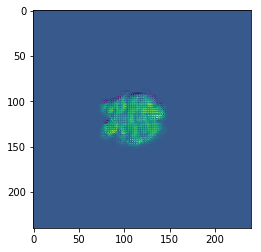

52749 count1 4851


In [30]:
print(pred[0,:,:,2])
plt.imshow(pred[0,:,:,2])
plt.show()
count0 = 0
count1 = 0
for i in pred[0,:,:,2]:
  for j in i:
    if j != 0.25:
      count1 += 1
     # print(j)
    else:
      count0 +=1
      #print(j)
print(count0,"count1",count1)

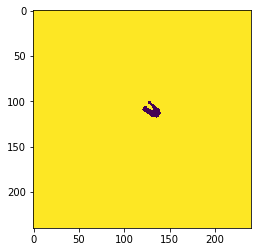

In [22]:
plt.imshow(hot_cal[0,:,:,0,0])
plt.show()